# Application to PBO data from California

In [1]:
import itertools
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import pyproj
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit
from dask.distributed import Client
import verde as vd
from vector3d import Vector3D, vector3d_jacobian
from vector3d.utils import plot_data, combinations, sample_from_grid

In [2]:
data = vd.datasets.fetch_california_gps().rename(columns=dict(
    velocity_east='east_velocity', velocity_north='north_velocity', velocity_up='up_velocity'))
region = vd.get_region((data.longitude, data.latitude))
# Convert from m/yr to mm/yr
for comp in ['east_velocity', 'north_velocity', 'up_velocity',
             'std_east', 'std_north', 'std_up']:
    data[comp] = 1e3*data[comp]
proj = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

In [3]:
data.describe()

,latitude,longitude,height,north_velocity,east_velocity,up_velocity,std_north,std_east,std_up
count,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000
mean,36.044371,240.854728,730.545576,17.404223,-15.061896,-0.043104,0.219548,0.229552,0.721676
std,2.372605,2.386124,743.368284,10.011721,8.853589,3.732877,0.193943,0.190813,0.562485
min,32.288454,235.691925,-93.543450,-1.740000,-36.170000,-52.070000,0.070000,0.060000,0.160000
25%,34.109556,238.949098,105.642360,8.640000,-23.552500,-0.490000,0.130000,0.130000,0.430000
50%,35.420948,241.353836,545.657065,17.800000,-14.310000,0.330000,0.160000,0.170000,0.590000
75%,37.713680,242.684481,1134.855828,25.222500,-7.570000,1.290000,0.230000,0.250000,0.850000
max,41.902326,244.968197,3865.311900,42.330000,5.680000,10.320000,3.200000,2.880000,8.870000


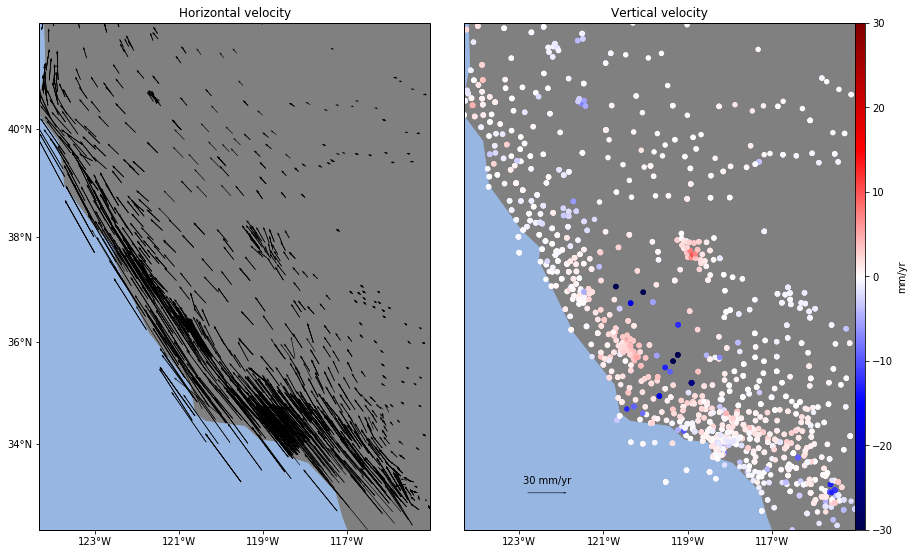

In [4]:
fig, ax = plot_data(data, 'pbo-data', maxabs=30)

## Split the data and make some utility function

In [5]:
full_data = (proj(data.longitude.values, data.latitude.values), 
             (data.east_velocity, data.north_velocity, data.up_velocity))
train, test = vd.train_test_split(*full_data, random_state=0, test_size=0.3)

In [6]:
def make_residuals(gridder):
    predicted = gridder.predict(proj(data.longitude.values, data.latitude.values))
    res = data.copy()    
    names = ['east_velocity', 'north_velocity', 'up_velocity']
    for pred, name in zip(predicted, names):
        res[name] = data[name] - pred
    return res

In [7]:
def make_grid(gridder):
    grid = gridder.grid(region=region, spacing=spacing, projection=proj,
                        dims=['latitude', 'longitude'], 
                        data_names=['east_velocity', 'north_velocity', 'up_velocity'])
    mask = vd.distance_mask((data.longitude, data.latitude), maxdist=0.5, 
                            region=region, spacing=spacing)
    grid = grid.where(mask)
    return grid

In [8]:
spacing = 12/60

## Simple fit

In [9]:
chain = vd.Chain([
    ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
    ('trend', vd.VectorTrend(1)),
    ('spline', Vector3D(depth=10e3, poisson=0.5, damping=1e1))
])
chain.fit(*train)
score = chain.score(*test)
print("R2 score:", score)
chain.fit(*full_data)

R2 score: 0.888612815783587


Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f22d4199d08>, region=None,
      spacing=20000.0)), ('trend', VectorTrend(degree=1)), ('spline', Vector3D(damping=10.0, depth=10000.0, flip_vertical=False, fudge=1e-05,
     poisson=0.5, region=None, shape=None, spacing=None))])

/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


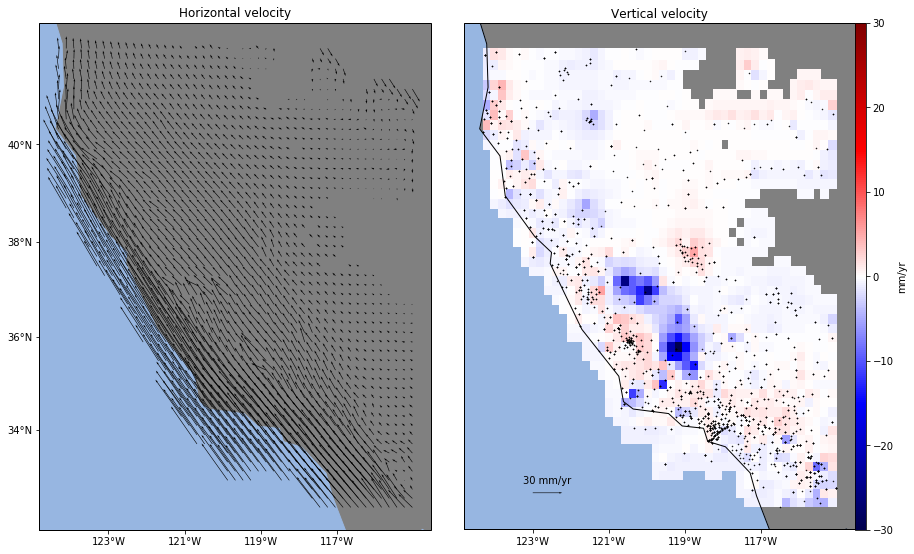

In [10]:
fig, axes = plot_data(make_grid(chain), 'pbo-simple-fit', every=1, 
                      scale=400, maxabs=30, pad=0.5, cmap='seismic', 
                      coords=(data.longitude, data.latitude))

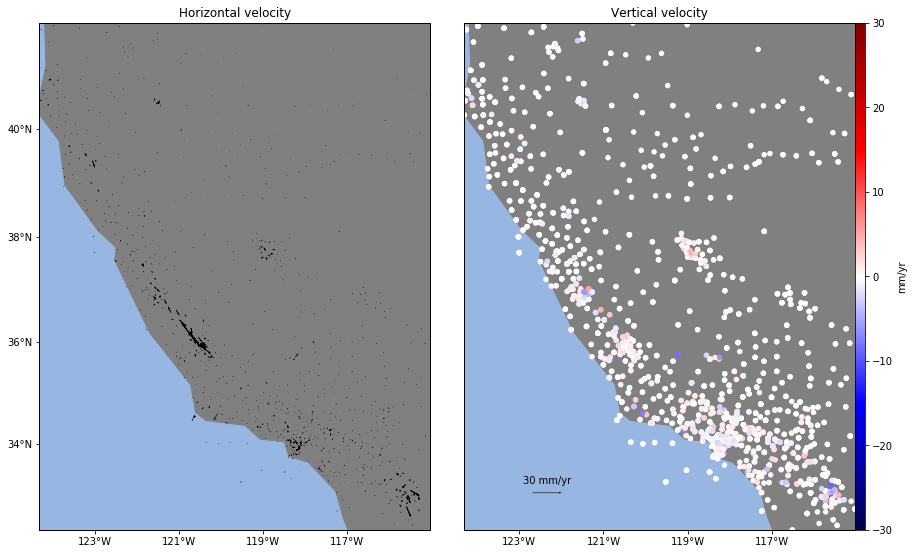

In [11]:
_ = plot_data(make_residuals(chain), 'pbo-simple-residuals', scale=400, maxabs=30)

## Cross-validated

In [12]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34663 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.74 GB


In [13]:
def fit_score(estimator, train, test):
    "Fit and score an estimator on the given arguments"
    return estimator.fit(*train).score(*test)

In [14]:
%%time
param_grid = combinations(
    damping=[0.01, 0.1, 1, 5, 10, 20, 50, 100],
    depth=[5e3, 10e3, 20e3, 50e3, 100e3],
    poisson=[-1, 0, 0.5],
    degree=[1],
)

chains = []
scores = []
for params in param_grid:
    degree = params.pop('degree')
    candidate = vd.Chain([
        ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
        ('trend', vd.VectorTrend(degree)),
        ('spline', Vector3D(**params))
    ])
    chains.append(candidate)
    scores.append(client.submit(fit_score, candidate, train, test))
best = client.submit(np.argmax, scores).result()
print("\nBest score:", scores[best].result())
cv_chain = chains[best].fit(*full_data)
print("\nBest chain:\n", cv_chain)


Best score: 0.9058099732236279

Best chain:
 Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f22d4199d08>, region=None,
      spacing=20000.0)), ('trend', VectorTrend(degree=1)), ('spline', Vector3D(damping=50, depth=10000.0, flip_vertical=False, fudge=1e-05,
     poisson=0.5, region=None, shape=None, spacing=None))])
CPU times: user 3.57 s, sys: 637 ms, total: 4.21 s
Wall time: 28.3 s


In [15]:
print("Number of combinations:", len(param_grid))

Number of combinations: 120


/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


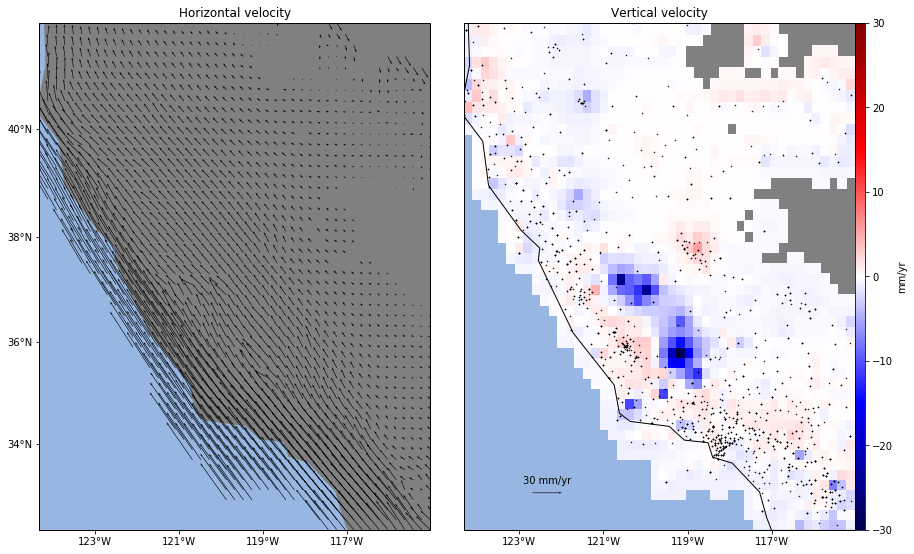

In [16]:
fig, axes = plot_data(make_grid(cv_chain), 'pbo-cv-fit', every=1, scale=400, maxabs=30, 
                      coords=proj(train[0][0], train[0][1], inverse=True))

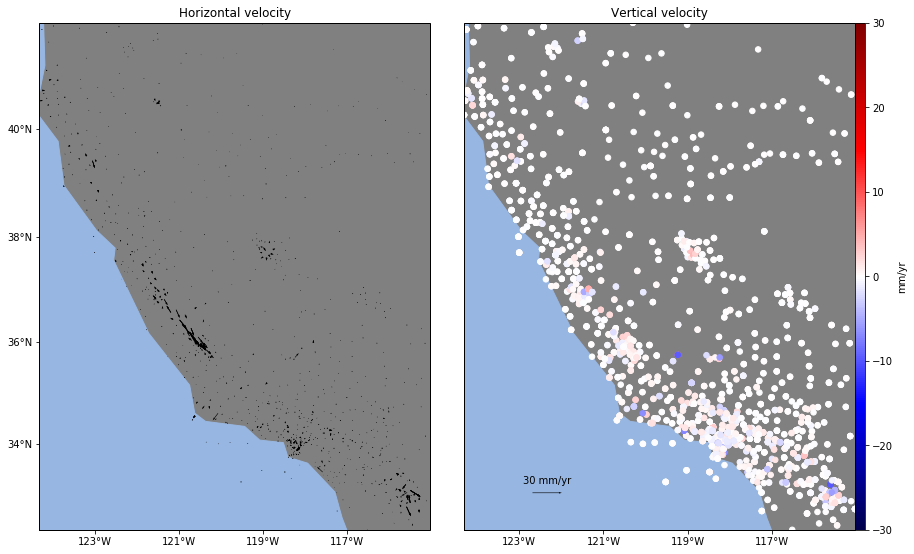

In [25]:
_ = plot_data(make_residuals(cv_chain), 'pbo-cv-residuals', maxabs=30, s=30, 
              scale=400)

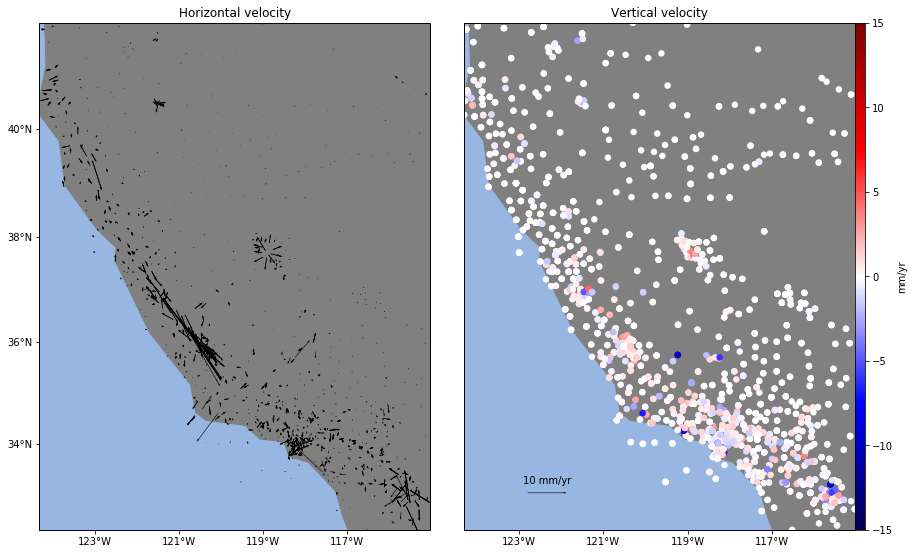

In [24]:
_ = plot_data(make_residuals(cv_chain), 'pbo-cv-residuals-exaggerated', maxabs=15, s=30, 
              scale=100, key=10)